# EARTHQUAKE PREDICTION WITH DEEP LEARNING

### 1. INTRODUCTION
>#### a. Aim of The Study
>#### b. The Way In Real Life
>#### c. Process Steps
>#### d. Imports
>#### e. Data Load and A Glance
### 2. FEATURE ENGINEERING
>#### a. Functions
>#### b. Feature Transformation
>#### c. Use of Earthquake Risk Map
### 3. MODELLING AND PREDICTION
>#### a. Features to Be Used
>#### b. Data Partition
>#### c. Functions
>#### d. Training
### 4. EVALUATION
>#### a. Loading Variables
>#### b. Plotting
>#### c. Test Results
>#### d. Afterwords

# 1. INTRODUCTION

## a. Aim of The Study

Along with this study, we are going to try to predict eartquakes, make our predictions as closer as possible to real values and find out whether there are any relations with former earthquakes and follows any patterns.

The prediction method is **one-step-forecast** which means that it only predicts the next earthquake. The reason fro using this method is that there are multiple values as mentioned belove to predict already. For multi-step forecast, many more sequences are predicted. When sequence quantity increases, the accuracy will begin to reduce. Also, it is it unnecessary to predict that much. Predicting the next is enough.

When it comes to earthquake prediction, we have 3 measurements to predict:

1. Place where it happens,

2. Time when it happens,

3. The magnitude of it.

Place component comprises from latitude and longitude values. So, there are 4 values to predict.

## b. The Way In Real Life

It is too hard to predict earthquakes. There are many parameters to be included in. Huge data from enormous quantity of sensors must be processed.

Real life earthquake prediction efforts focus on predicting the next few seconds to warn people. Many instant-measured parameters are used. On any changes of the state, it is tried to predict whether there will be an earthquake or not.

Up to September 2019, accuracy score of that prediction was 58%. Since then, it is 84%. All efforts focus on very near future such as 6-9 seconds to be able to alarm  people just before.

## c. Process Steps

1. The dataset and supplementary materials are taken from AFAD website (https://deprem.afad.gov.tr/depremkatalogu).

2. After downloading and importing dataset, feature engineering comes next.
>* At this step, date-time data converted to days and hour-day rate.
>* A risk map is processed to be able to use in the model.
>* Many scatter plots are drawn to see feature relations.
>* Heatmap is plotted to see correlations.

3. A graph search algoritm is written to try hundreds of variations to find the best model and hyperparameters.

  There are some built-in algoritms to achieve that. But, they do not meet the need. Some causes are:
  >* Google Colab does not allow to use it more than 12 hours. Also, if there are no transactions for a while, runtime disconnects.
  >* When there is an interruption due to any problems, it is mandatory to begin from the very beginning. The time spent becomes rubbish.

  With this algoritm, values can be saved in time, the process can be interrupted and can be resumed.

4. Models are compared and tested. Best models are visualized.

## d. Imports

In [41]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Necessary Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import keras

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, date
from keras import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

## e. Data Load and A Glance

In [0]:
# Path oh the dataset
path="/content/drive/My Drive/Colab Notebooks/Data_Science/odev/Project_5_Data/"

# Name of the dataset
file="0_Earthquakes.csv"

# Loading the dataset
data = pd.read_csv(os.path.join(path, file), sep=',', encoding="latin_1")

In [0]:
data=data.rename(columns={"Zaman (UTC)":"Time (UTC)",
                          "Kaynak Aç?klama 1":"Source Explanation 1",
                          "Enlem":"Latitude",
                          "Boylam":"Longitude",
                          "Derinlik":"Depth",
                          "Sabit Derinlik":"Constant Depth",
                          "Kaynak No 2":"Source No 2",
                          "Kaynak Aç?klama 2":"Source Explanation 2",
                          "Tip":"Type",
                          "Büyüklük":"Magnitude",
                          "Kaynak No 3":"Source No 3",
                          "Kaynak Aç?klama 3":"Source Explanation 3",
                          "Yer":"Placement"})

In [45]:
data.head()

,No,Time (UTC),Ref1,Source Explanation 1,Latitude,Longitude,Depth,Constant Depth,Source No 2,Source Explanation 2,Type,Magnitude,Source No 3,Source Explanation 3,Placement
0,0,2018-10-14 15:08:32,0,,36.8578,44.4161,16.97,-,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA,-
1,0,2018-10-10 09:08:24,0,,37.4341,35.8520,7.02,-,7,AFAD-DDA,Mw,4.1,7,AFAD-DDA,-
2,0,2018-10-02 15:29:03,0,,37.6878,37.4016,10.27,-,7,AFAD-DDA,Mw,4.4,7,AFAD-DDA,-
3,0,2018-09-28 00:26:32,0,,37.2003,30.4376,78.07,-,7,AFAD-DDA,Mw,4.0,7,AFAD-DDA,-
4,0,2018-09-26 02:52:21,0,,35.6846,26.7266,42.77,-,7,AFAD-DDA,Mw,4.5,7,AFAD-DDA,-


In [46]:
data.describe()

,No,Ref1,Latitude,Longitude,Depth,Source No 2,Magnitude,Source No 3
count,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000
mean,5499.501977,0.088683,38.461697,33.084180,24.983027,10.145117,4.467600,6.776544
std,3976.820893,0.406717,1.634089,6.280525,27.758711,12.798807,0.485719,5.412018
min,0.000000,0.000000,35.670000,25.850000,0.000000,1.000000,4.000000,1.000000
25%,1865.250000,0.000000,36.992250,27.805475,10.000000,5.000000,4.100000,5.000000
50%,5261.500000,0.000000,38.621150,30.159500,13.000000,5.000000,4.300000,5.000000
75%,8819.750000,0.000000,39.565500,39.256775,33.000000,7.000000,4.700000,7.000000
max,12674.000000,4.000000,42.386900,45.149500,212.000000,41.000000,7.900000,40.000000


# 2. FEATURE ENGINEERING

## a. Functions

1. "calculate_days" function calculates the days passed between 2 dates. It is used for two features. First, it calculates the days between sequential earthquakes. Second, it calculates the days passed from the date-time 1900-01-01 00:00:000.

2. "hour_rate" function is used for calculating the hour rate in the day. {e.g. 13:24:000 is calculated as (13 * 60 + 24) / (24 * 60)}

3. It is given latitude and longitude values to "risk_grader" function and it finds the risk grade from the processed ready-to-use risk map.

In [0]:
# Function to calculate the days passed
def calculate_days(date_string_1, date_string_2):
  date_num_1=datetime.strptime(date_string_1, '%Y-%m-%d %H:%M:%S')
  date_num_2=datetime.strptime(date_string_2, '%Y-%m-%d %H:%M:%S')

  # Sorting the dates descending
  if date_num_2>date_num_1:
    a=date_num_1
    date_num_1=date_num_2
    date_num_2=a

  # Concatenating dates
  d1=date(year=date_num_1.year, month=date_num_1.month, day=date_num_1.day)
  d2=date(year=date_num_2.year, month=date_num_2.month, day=date_num_2.day)

  return (d1-d2).days

#-------------------------------------------------------------------------

# Function to scale the time between [0,1)
def hour_rate(date_string):
  date_num=datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')

  # Calculating the rate
  hr=((date_num.hour*60) + date_num.minute) / (24*60)

  return hr

## b. Feature Transformation

Date-time column represents an incompatible data for analysis. This should be seperated into date and time. Besides, these two can also be incompatible due to different types of values. It is better to convert them into a single value.

Columns containing string values can be omitted.

In [0]:
data["Time Gap"]=[calculate_days(data["Time (UTC)"][i], data["Time (UTC)"][i-1]) if i>0 else 0 for i in range(0, len(data["Time (UTC)"]))]

data["Hour-Day Ratio"]=[hour_rate(data["Time (UTC)"][i]) for i in range(0, len(data["Time (UTC)"]))]

In [0]:
begin_date="1900-01-01 00:00:00"

data["Days"]=[calculate_days(data["Time (UTC)"][i], begin_date) for i in range(0, len(data["Time (UTC)"]))]

data["Month"]=[datetime.strptime(i, '%Y-%m-%d %H:%M:%S').month for i in data["Time (UTC)"]]

In [0]:
data["Constant Depth"]=data["Constant Depth"].replace({"-":0, "*":1})

data=data.sort_values(by="Days", ascending=True).reset_index(drop=True)

data=data.drop(["No", "Ref1", "Source Explanation 1", "Source No 2", 
                "Source Explanation 2", "Source No 3", "Source Explanation 3", 
                "Placement", "Type", "Time (UTC)"], axis=1)

## c. Use of Earthquake Risk Map

While looking through AFAD website for more information, there seemed a this risk map. It can add some useful information to the model. When risk map is compared with real earthquake happenings, the relationship can be observed.

Noises such as city names and borders are reduced. Recovering process uses some convolution-like filters with increasing sizes and filter-sized strides. On each epoch, it replaces all pixels to filter max or filter min.

![Risk Map](https://drive.google.com/uc?id=1CiB5-faBCf7dNeUioznTh4WeKf9NEEAe)

![Earthquake Map](https://drive.google.com/uc?id=1ZaghIIBtdtP__KBUfjKjVmWDUqv3GlVQ)

On the scale which is shown with yellow and red gradients, if we go to right, quake risk increases. When both maps are compared to each other, quakes with bigger than 6 magnitude score, mostly overlaps with the highest risk grades.

In [0]:
# Loading risk map
raw_img=cv2.imread(os.path.join(path, "0_risk_map.jpg"), cv2.IMREAD_GRAYSCALE)

In [0]:
# Recovering process

# Initial values
size=6
increment=2
epoch=4
recovered_img=raw_img.copy()

# Filtering
for i in range(0,epoch):
  
  width_step=np.shape(recovered_img)[1]/size
  height_step=np.shape(recovered_img)[0]/size

  # Filter Striding
  for h in range(0, int(height_step)):
    for w in range(0, int(width_step)):

      window=recovered_img[h*size:(h+1)*size, w*size:(w+1)*size]

      # At first epoch, values are maximized; then minimized. 
      if i==0:
        window=window.max()
      else:
        window=window.min()

      recovered_img[h*size:(h+1)*size, w*size:(w+1)*size]=window

  size+=increment

#### Values differentiating between 0 and 255 are replaced a certain value according to threshold values. Threshold values are found experimentally.

In [0]:
# Value Replacement
risk_map=recovered_img.copy()

# Threshold values
high=90
medium=175
low=235
no_data=250
default=5

# Replacement
risk_map=np.where(risk_map<=high, 4, risk_map)
risk_map=np.where(((risk_map>high) & (risk_map<=medium)), 3, risk_map)
risk_map=np.where(((risk_map>medium) & (risk_map<=low)), 2, risk_map)
risk_map=np.where(((risk_map>low) & (risk_map<=no_data)), 1, risk_map)
risk_map=np.where(risk_map>no_data, default, risk_map)

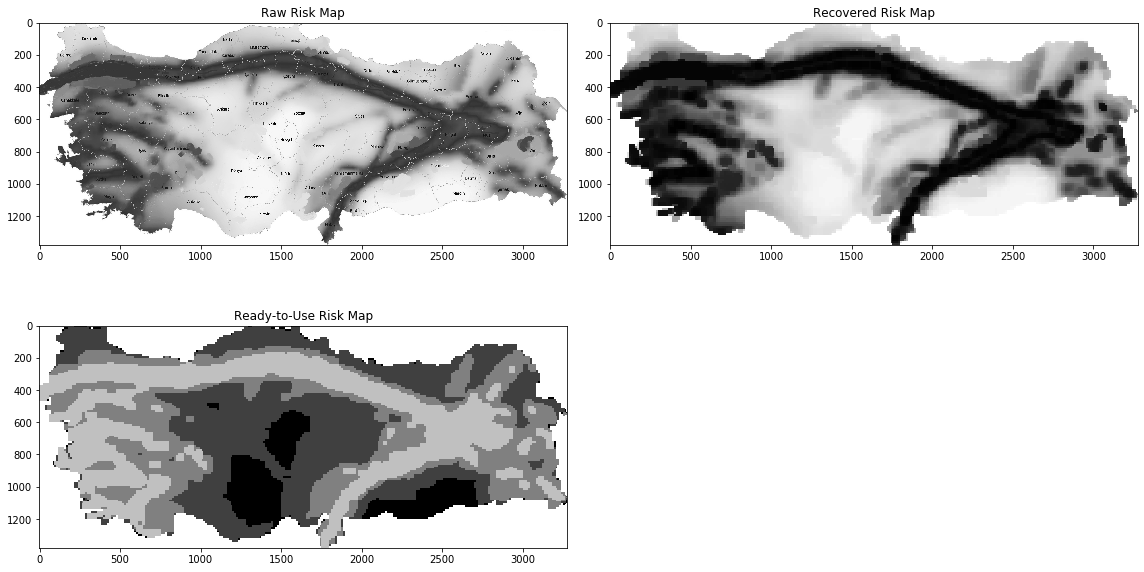

In [54]:
# Visualization of all 3 maps
map_names={"Raw Risk Map":raw_img, "Recovered Risk Map":recovered_img, "Ready-to-Use Risk Map":risk_map}

fig=plt.figure(figsize=(16, 9))

for i, val in enumerate(map_names):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(map_names[val], cmap="gray")
    plt.title(val)
    plt.tight_layout()

plt.show()

For being able to use risk map, these steps can be followed:

1. Cropping unnecessary parts of the map,
2. Reducing noises such as city names and borders. At this step, an extending-sized frame passed over the map several times equalizing all values to frame minimum/maximum.
3. Finding threshold values for risk grades and replacing all values with a grade number on the map. Threshold values are found experimentally.

Map results of these steps seem like above.

In [0]:
#Function to find risk class
def risk_grader(latitude, longitude):
  # Begin and end coordinates of the map used.
  west=25.67
  east=44.81
  south=35.81
  north=42.10

  # Checking coordinates whether involved by map
  if (longitude<west) or (longitude>east) or (latitude<south) or (latitude>north):
    return default

  # Calculating ratio between real land piece and map image pixels
  real_width=east-west
  real_height=north-south

  map_width=np.shape(risk_map)[1]
  map_height=np.shape(risk_map)[0]

  width_ratio=map_width/(real_width*100)
  height_ratio=map_height/(real_height*100)

  # Calculating pixels to look up for the grade
  easting=longitude-west
  northing=latitude-south

  pixel_to_right=int(round(easting*100*width_ratio))
  pixel_to_up=map_height-int(round(northing*100*height_ratio))

  # Correction of the error caused by floating points
  if pixel_to_right>=map_width:
    pixel_to_right=map_width-1

  if pixel_to_up>=map_height:
    pixel_to_up=map_height-1

  # reading risk grade from the map array
  grade=risk_map[pixel_to_up, pixel_to_right]

  return grade

In [0]:
# Finding risk grade for every earthquake
data["Risk Grade"]=[risk_grader(data["Latitude"][i], data["Longitude"][i]) for i in range(len(data["Latitude"]))]

In [57]:
# A glance on dataset
data.head()

,Latitude,Longitude,Depth,Constant Depth,Magnitude,Time Gap,Hour-Day Ratio,Days,Month,Risk Grade
0,37.79,28.21,10.0,1,4.4,6,0.645833,17,1,4
1,39.54,26.14,10.0,1,5.2,3,0.125000,23,1,4
2,37.63,37.37,10.0,1,4.8,3,0.104167,26,1,4
3,37.83,27.71,10.0,1,4.4,7,0.041667,29,1,4
4,38.12,31.29,10.0,1,5.7,1,0.631250,36,2,3


Last state of the dataset is above. There are 10 features to use. Occasionally, features need extra transformation such as taking logaritm or square root. This can make features better fit for the target. So, logaritms of all features are taken to see relations between pairs.

#### Values are taken logaritms and concatenated to dataset due to further investigation.

In [0]:
# Calculating and concatenating
extended_data=pd.DataFrame()

extended_data=data.copy()

for i in extended_data.columns:
  extended_data["Log."+i]=np.log(extended_data[i]+0.01)

#### All parameters are scatter-plotted whether there are any relationships.

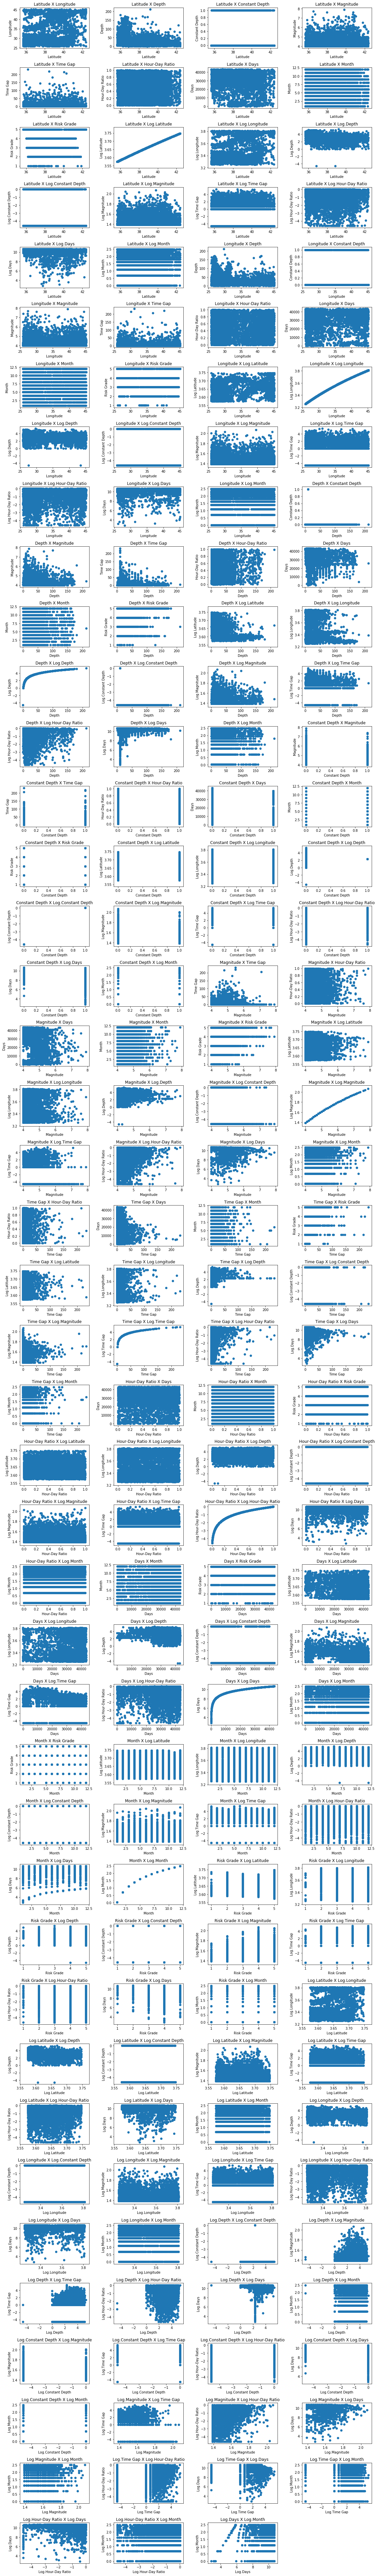

In [59]:
# Scatter Plots
lines=(((len(extended_data.columns)-1)*(len(extended_data.columns)))/8)+1
k=1

subplt=plt.figure(figsize=(16, 120))

for i in range(0, len(extended_data.columns)-1):
  for j in range(i+1, len(extended_data.columns)-1):
    subplt.add_subplot(lines, 4, k)
    
    plt.scatter(extended_data[extended_data.columns[i]], extended_data[extended_data.columns[j]])
    plt.title("{} X {}".format(extended_data.columns[i], extended_data.columns[j]))
    plt.xlabel(extended_data.columns[i])
    plt.ylabel(extended_data.columns[j])

    k+=1

plt.tight_layout()
plt.show()

There are  171 scatter plots. Most of the plots do not give much information. Correlations are shown below.

#### Correlations are checked by use of heatmap.

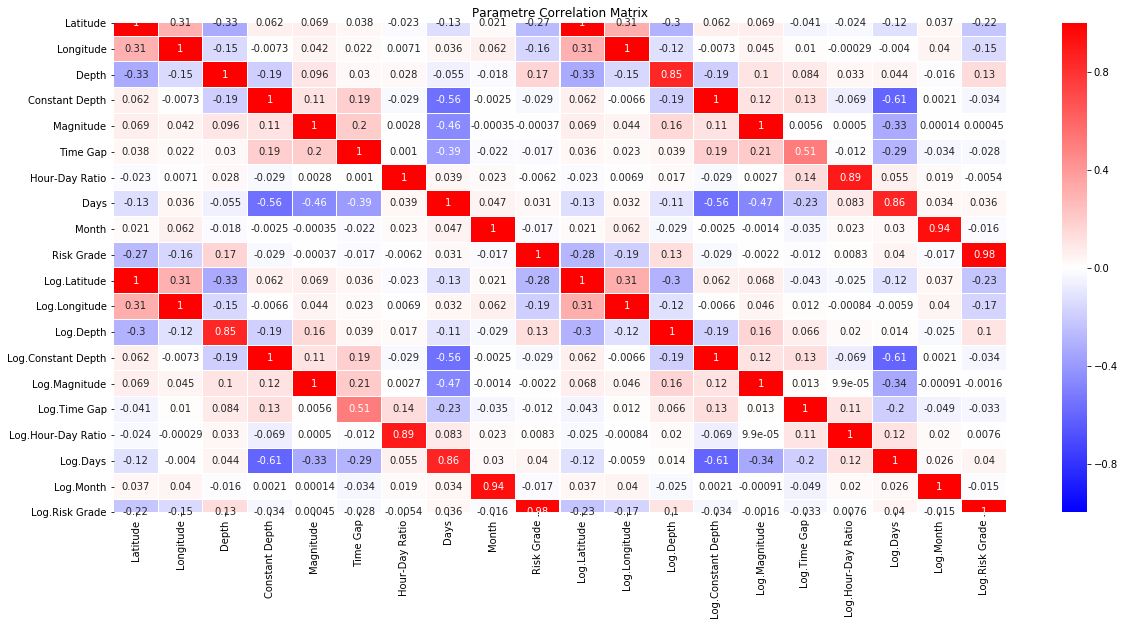

In [60]:
extended_corr=extended_data.corr()

plt.figure(figsize=(20,9))
sns.heatmap(extended_corr, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Parametre Correlation Matrix")
plt.show()

Most powerful correlations have approximately 0.5 points. As it is seen, dataset has weak correations. It is going to be hard to predict true values.

#### At the end of this processes, parameter relations are shown below:

![](https://drive.google.com/uc?export=view&id=1vdlpv3Lk_yzi8fKMFzUwPUQWZpwMACzS)

* Red lines represents inverse correlations,
* Green lines represents direct correlations,
* Blue lines represents mixed correlations (begins with direct correlation and then turn into inverse coorelation.)

All features seen in the graphic are added to models.

# 3. MODELLING AND PREDICTION

Some parts of earthquake dataset are time-series (due to aftershock quakes and fault line breakage) and some parts are not related to others. It is hard to determine the model to choose, whether dense network or LSTM. So, it is better to try both.

## a. Features to Be Used

In [0]:
new_labels=["Latitude", "Longitude", "Days", "Magnitude", 
            "Depth", "Constant Depth", "Risk Grade", "Time Gap", 
            "Log.Days", "Log.Hour-Day Ratio"]

new_data=extended_data[new_labels]

## b. Data Partition

#### Definings

In [0]:
percentage=0.25

duration=20

test_size=int(len(new_data)*percentage)

#### Dense layer partition and scaling

4 of the features are going to be predicted and remaining 6 of them are going to be trained.

In [0]:
# Dense Network Dataset partition
per=0.25

test_size=int(len(new_data)*per)

new_train=new_data[0:len(new_data)-test_size]
new_test=new_data[len(new_data)-test_size:len(new_data)]

X_train_Dense=new_train.iloc[:,4:]
X_test_Dense=new_test.iloc[:,4:]

y_train_Dense=new_train.iloc[:,0:4]
y_test_Dense=new_test.iloc[:,0:4]

# Data set scaling
scaler_Dense_X=MinMaxScaler(feature_range=(0,1))
scaler_Dense_y=MinMaxScaler(feature_range=(0,1))

X_train_Dense=scaler_Dense_X.fit_transform(X_train_Dense)
X_test_Dense=scaler_Dense_X.fit_transform(X_test_Dense)

y_train_Dense=scaler_Dense_y.fit_transform(y_train_Dense)
y_test_Dense=scaler_Dense_y.fit_transform(y_test_Dense)

#### LSTM layer partition and scaling

All of the features are going to be trained and 4 of them are going to be predicted. Target features are 1-shifted.

In [0]:
# Dense Network Dataset Scaling and Partition

# Definings
scaler_LSTM_X=MinMaxScaler(feature_range=(0,1))
scaler_LSTM_y=MinMaxScaler(feature_range=(0,1))

new_data_array=np.array(new_data)

X_LSTM, y_LSTM=[], []

# y Subset Seperation and Scaling
y_LSTM=new_data_array[duration:,0:4]
y_LSTM=scaler_LSTM_y.fit_transform(y_LSTM)

# X Subset Seperation an Scaling
new_data_array=scaler_LSTM_X.fit_transform(new_data_array)

for i in range(0,len(new_data_array)-duration):
  partial=new_data_array[i:i+duration]
  X_LSTM=np.append(X_LSTM, partial)

X_LSTM=np.reshape(X_LSTM, (np.shape(new_data_array)[0]-duration, duration, np.shape(new_data_array)[1]))

# Partition to Train and Test Subsets
X_train_LSTM=X_LSTM[0:len(X_LSTM)-test_size]
X_test_LSTM=X_LSTM[len(X_LSTM)-test_size:]

y_train_LSTM=y_LSTM[0:len(y_LSTM)-test_size]
y_test_LSTM=y_LSTM[len(y_LSTM)-test_size:]

## c. Functions

#### This function reduces loss quantity. To do that, it calculates mean at every step.

In [0]:
def loss_reduce(loss):
  new_loss=[]
  fold=int(len(loss)/np.min(epoch))

  for i in range(0,np.min(epoch)):
    local_mean=np.mean(loss[fold*i:fold*(i+1)])
    new_loss.append(local_mean)

  return new_loss

#### This function finds the parameter values to be able to resume the deep learning model.

In [0]:
# Finding values for beginning state
def find_values(builder="Dense"):

  # Initial values
  loss_file, value_file, files=False, False, False
  hid, opt, bat, epo, row_num=0, 0, 0, 0, 0
  min_score=1000000

  # Checking whether the necessary files are present
  for file_name in os.listdir(path):
    if "loss_"+builder+".csv"==file_name:
      loss_file=True

    if "values_"+builder+".csv"==file_name:
      value_file=True

    # Reading last processed indices, data lenght and minimum score
    if loss_file and value_file:
      files=True
      data=pd.read_csv(os.path.join(path, "values_"+builder+".csv"))
      row_num=len(data)
      hid=hidden.index(data["hidden"][row_num-1])
      opt=optimizers.index(data["optimizer"][row_num-1])
      bat=batch.index(data["batch"][row_num-1])
      epo=epoch.index(data["epochs"][row_num-1])
      min_score=data["evaluation_0"].min()

      # Shifting values
      if epo<len(epoch)-1:
        epo+=1
      else:
        epo=0
        if bat<len(batch)-1:
          bat+=1
        else:
          bat=0
          if opt<len(optimizers)-1:
            opt+=1
          else:
            opt=0
            if hid<len(hidden)-1:
              hid+=1
            else:
              return None

  return hid, opt, bat, epo, row_num, min_score, files

#### This function builds the model which is set before.

In [0]:
# Building preset models
def model_builder(builder="Dense", hidden=32, optimizer="rmsprop"):
  if builder=="Dense":
    model=Sequential()

    model.add(Dense(hidden, activation="relu", input_shape=(6,)))
    model.add(BatchNormalization())
    model.add(Dense(4))

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])

  if builder=="LSTM":
    model=Sequential()

    model.add(GRU(hidden, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(units=hidden))
    model.add(Dense(units=4))

    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

  return model

#### This function records evaluation, loss and other values.

In [0]:
# Registering all values
def register(loss, values, evaluation):
  # Fixing the best model
  if evaluation[0]<min_score:
    min_score=evaluation[0]
    model.save(os.path.join(path, "best_model_"+model_type+".h5"))

  loss.to_csv(os.path.join(path, "loss_"+model_type+".csv"), index=False)
          
  values.to_csv(os.path.join(path, "values_"+model_type+".csv"), index=False)

#### This function trains the model with parameters given, records values and the best model.

In [0]:
# Searching of hyperparameters
def GraphSearch(model_type):
  # remounting drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Getting beginning values
  files=False
  hid, opt, bat, epo, row_num=0, 0, 0, 0, 0
  min_score=1000000
  begin_state=find_values(builder=model_type)

  if begin_state==None:
    print("\nAll done!..")
    return

  row=begin_state[4]
  min_score=begin_state[5]

  # Loading relevant dataset
  if model_type=="LSTM":
    X_train=X_train_LSTM
    X_test=X_test_LSTM
    y_train=y_train_LSTM
    y_test=y_test_LSTM

  else:
    X_train=X_train_Dense
    X_test=X_test_Dense
    y_train=y_train_Dense
    y_test=y_test_Dense

  # Reading dataframes
  if begin_state[6]:
    loss=pd.read_csv(os.path.join(path, "loss_"+model_type+".csv"))
    values=pd.read_csv(os.path.join(path, "values_"+model_type+".csv"))
  else:
    loss=pd.DataFrame()
    values=pd.DataFrame()

  # Graph searching
  for hid in hidden[begin_state[0]:]:
    for opt in optimizers[begin_state[1]:]:
      for bat in batch[begin_state[2]:]:
        for epo in epoch[begin_state[3]:]:

          print("{} / {} ".format(row+1, len(hidden)*len(optimizers)*len(batch)*len(epoch)))

          # Training
          model=model_builder(builder=model_type, hidden=hid, optimizer=opt)

          record=model.fit(X_train, y_train, epochs=epo, batch_size=bat, validation_split=0.25, verbose=0)

          # Evaluating and collecting records
          evaluation=model.evaluate(X_test, y_test)

          loss[row]=loss_reduce(record.history["loss"])

          values=values.append({"hidden":hid,
                                "optimizer":opt,
                                "batch":bat,
                                "epochs":epo,
                                "evaluation_0":evaluation[0],
                                "evaluation_1":evaluation[1]},
                                ignore_index=True)

          # Registering
          try:
            # Fixing the best model
            if evaluation[0]<min_score:
              min_score=evaluation[0]
              model.save(os.path.join(path, "best_model_"+model_type+".h5"))

            loss.to_csv(os.path.join(path, "loss_"+model_type+".csv"), index=False)
          
            values.to_csv(os.path.join(path, "values_"+model_type+".csv"), index=False)

          except:
            from google.colab import drive
            drive.mount('/content/drive')

            # Fixing the best model
            if evaluation[0]<min_score:
              min_score=evaluation[0]
              model.save(os.path.join(path, "best_model_"+model_type+".h5"))

            loss.to_csv(os.path.join(path, "loss_"+model_type+".csv"), index=False)
          
            values.to_csv(os.path.join(path, "values_"+model_type+".csv"), index=False)

          row+=1

          print("Done!..\n")

## d. Training

#### Dense Neural Network

With the functions written above, many different networks can be searched to find the best model and hyperparameters. Here are 192 of them:

In [70]:
# Parameters and running of dense model
hidden=[32, 64, 100, 128]
optimizers=["rmsprop", "adam", "SGD"]
batch=[32, 64, 128, 256]
epoch=[100, 300, 500, 700]

GraphSearch("Dense")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

All done!..


#### LSTM network

Belove are LSTM models. 27 of LSTM models are searched. In total, 219 models are tested. Surely, tens of models are also tested before that to find the best structure.

In [71]:
# Parameters and running of LSTM model
hidden=[30, 50, 80]
optimizers=["rmsprop"]
batch=[32, 64, 128]
epoch=[250, 500, 750]

GraphSearch("LSTM")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

All done!..


# 4. EVALUATION

At this part, predictions are made with both bests of Dense and LSTM. But first, models 

## a. Loading Variables

In [0]:
# Loading files

# Dense Model
values_Dense=pd.read_csv(os.path.join(path, "values_Dense.csv"))
loss_Dense=pd.read_csv(os.path.join(path, "loss_Dense.csv")).T
model_Dense=keras.models.load_model(os.path.join(path, "best_model_Dense.h5"))

# LSTM Model
values_LSTM=pd.read_csv(os.path.join(path, "values_LSTM.csv"))
loss_LSTM=pd.read_csv(os.path.join(path, "loss_LSTM.csv")).T
model_LSTM=keras.models.load_model(os.path.join(path, "best_model_LSTM.h5"))

In [0]:
# Definings for easy use
variables=["epochs", "batch", "optimizer", "hidden"]

types=["Dense", "LSTM"]

dict={"values_Dense":values_Dense,
      "values_LSTM":values_LSTM,
      "loss_Dense":loss_Dense,
      "loss_LSTM":loss_LSTM}

## b. Plotting

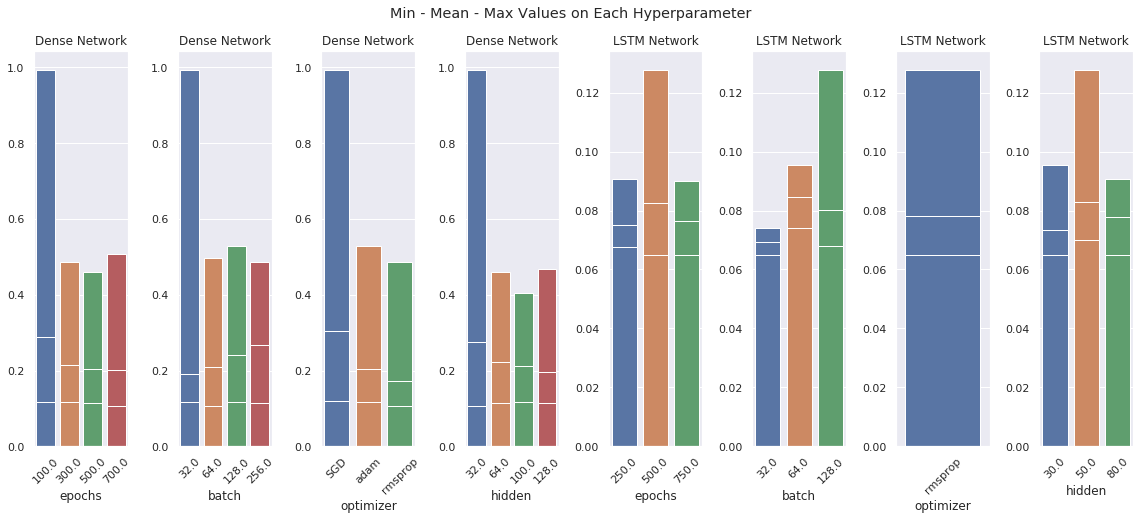

In [74]:
# Models 
sns.set(style="darkgrid")
fig=plt.figure(figsize=(16, 7))
i=1

plt.suptitle("Min - Mean - Max Values on Each Hyperparameter", y=1.03)
for val1 in types:
  for val2 in variables:
    fig.add_subplot(1, 8, i)

    a=dict["values_"+val1].groupby(val2)["evaluation_0"].max()
    sns.barplot(x=a.index, y=a.values)
    b=dict["values_"+val1].groupby(val2)["evaluation_0"].mean()
    sns.barplot(x=b.index, y=b.values)
    c=dict["values_"+val1].groupby(val2)["evaluation_0"].min()
    sns.barplot(x=c.index, y=c.values)

    plt.title(val1+" Network")
    plt.xticks(rotation=45)
    plt.tight_layout()
    i+=1
plt.show()

Graphs are shown with different axis scales. Because, LSTM models perform pretty well according to Dense models. 

On each bar;

* Lower lines show model minimum, 
* Upper lines show model mean,
* Bar tops show model maximum.

Best results and hyperparameters.

In [75]:
values_Dense[values_Dense["evaluation_0"]==values_Dense["evaluation_0"].min()]

,batch,epochs,evaluation_0,evaluation_1,hidden,optimizer
7,64.0,700.0,0.107584,0.288733,32.0,rmsprop


In [76]:
values_LSTM[values_LSTM["evaluation_0"]==values_LSTM["evaluation_0"].min()]

,batch,epochs,evaluation_0,evaluation_1,hidden,optimizer
19,32.0,500.0,0.064794,0.197313,80.0,rmsprop


Result changings according to hyperparameter.

In [0]:
# Finds unique values and stores in an array
def find_hue(array):
  hue=[]
  unique_values=array.unique()

  for i in array:
    for j, val in enumerate(unique_values):
      if i==val:
        hue=np.append(hue, j)

  return hue

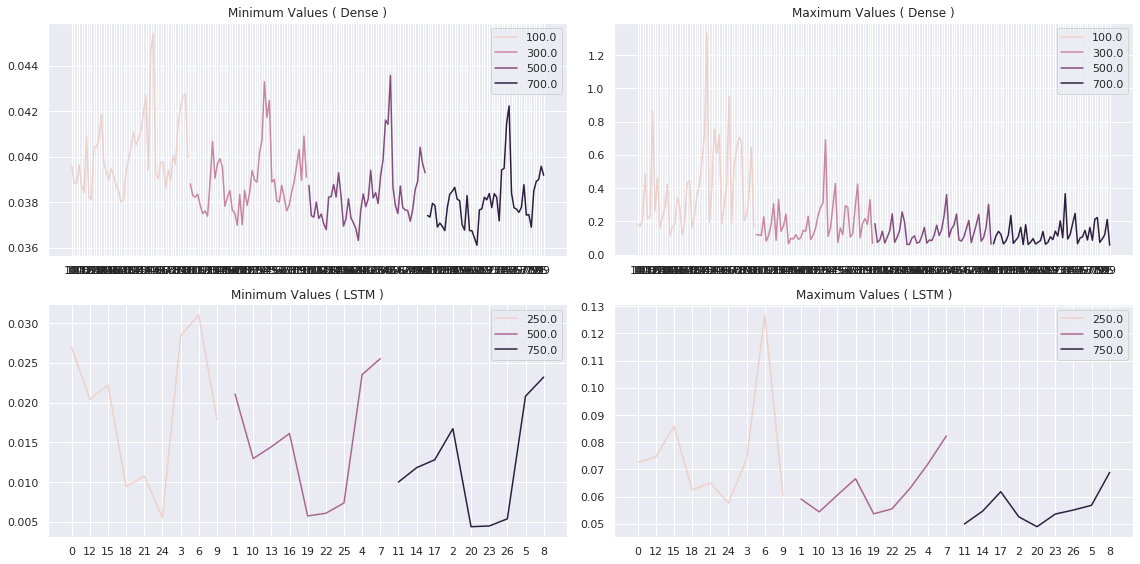

In [78]:
variables=["epochs", "batch", "optimizer", "hidden"]

col="epochs" # Change this and run again!

count=0
fig=plt.figure(figsize=(16, 8))

for i in types:
  mod_type=i
  s1="loss_"+mod_type
  s2="values_"+mod_type

  fig.add_subplot(2, 2, count*2+1)
  sns.lineplot(x=dict[s1].index, y=dict[s1].T.min(), hue=find_hue(dict[s2][col]))
  plt.title("Minimum Values ( "+i+" )")
  plt.legend(dict[s2][col].unique())

  fig.add_subplot(2, 2, count*2+2)
  sns.lineplot(x=dict[s1].index, y=dict[s1].T.max(), hue=find_hue(dict[s2][col]))
  plt.title("Maximum Values ( "+i+" )")
  plt.legend(dict[s2][col].unique())

  count+=1

plt.tight_layout()
plt.show()

As can be seen above:

* LSTM models are much more better than Dense models,
* Dense models can differentiate on a large scale,
* All Dense models' minimum performances are similar to each other which can mean "Dense models' best performances are restricted for this kind of datasets."
* Hyperparameters achieve different effects on different model types. But generally, it is better to use higher epochs and lower hidden layers.

## c. Test Results

Here are prediction results on test set.

In [0]:
pred_Dense=model_Dense.predict(X_test_Dense)
pred_LSTM=model_LSTM.predict(X_test_LSTM)

pred_Dense=scaler_Dense_y.inverse_transform(pred_Dense)
pred_LSTM=scaler_LSTM_y.inverse_transform(pred_LSTM)
real_values=scaler_Dense_y.inverse_transform(y_test_Dense)

#### Coordinate Predictions

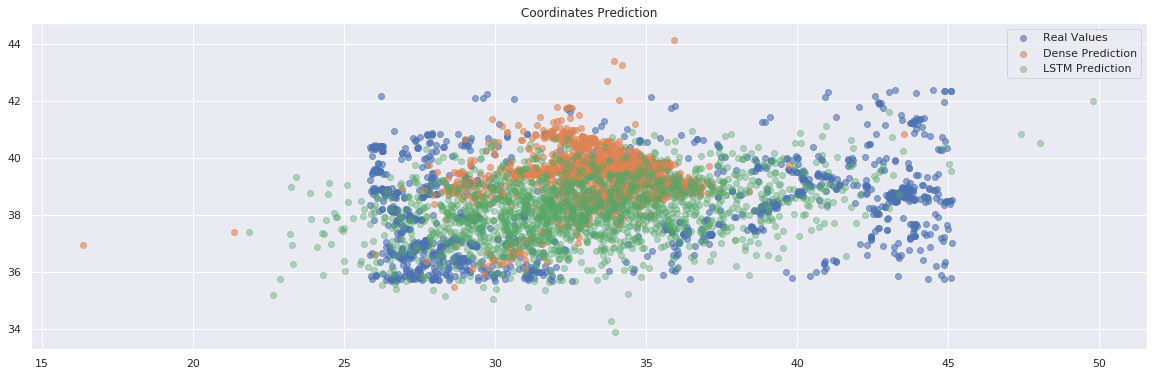

In [80]:
plt.figure(figsize=(20,6))
plt.scatter(real_values.T[1], real_values.T[0], label="Real Values", alpha=0.6)
plt.scatter(pred_Dense.T[1], pred_Dense.T[0], label="Dense Prediction", alpha=0.6)
plt.scatter(pred_LSTM.T[1], pred_LSTM.T[0], label="LSTM Prediction", alpha=0.4)
plt.title("Coordinates Prediction")
plt.legend()
plt.show()

Both models are far away from predicting the truth. But if one must be chosen, it is LSTM.

#### Days Prediction

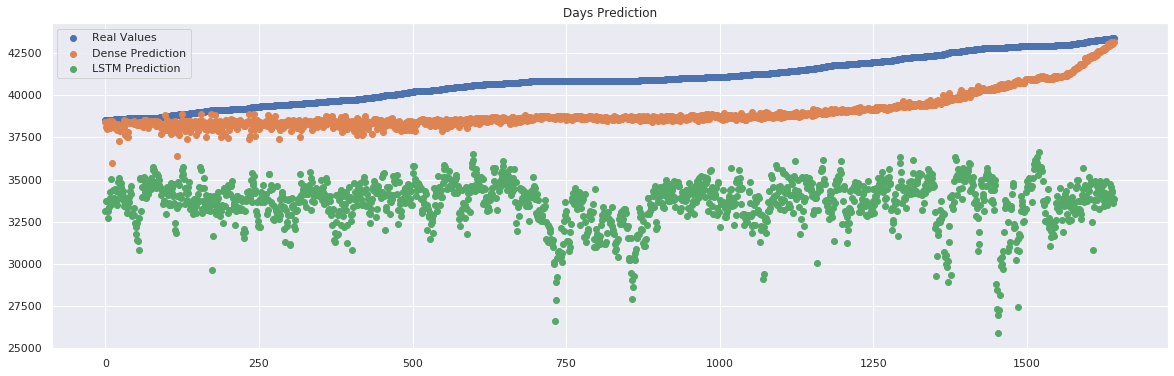

In [81]:
ind=[i for i in range(0, len(real_values))]

plt.figure(figsize=(20,6))
plt.scatter(ind, real_values.T[2], label="Real Values")
plt.scatter(ind, pred_Dense.T[2], label="Dense Prediction")
plt.scatter(ind, pred_LSTM.T[2], label="LSTM Prediction")
plt.title("Days Prediction")
plt.legend()
plt.show()

LSTM performed bad. Dense model can give hope for days prediction.

#### Magnitude Prediction

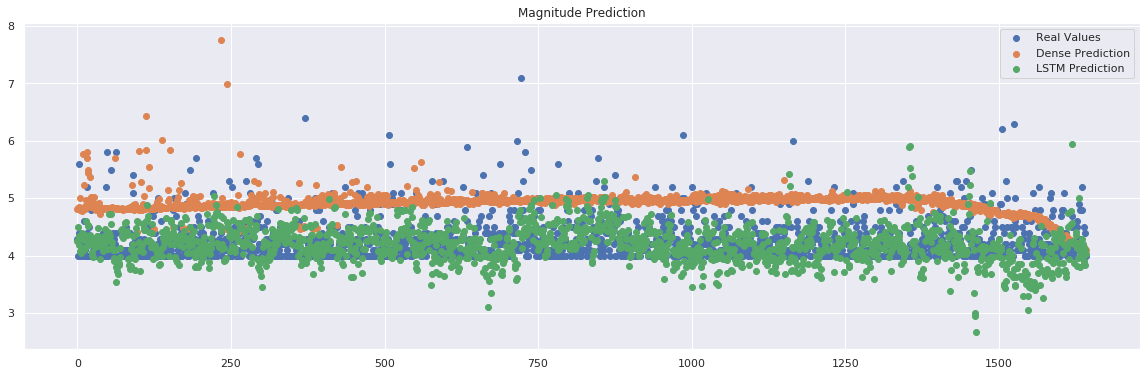

In [82]:
plt.figure(figsize=(20,6))
plt.scatter(ind, real_values.T[3], label="Real Values")
plt.scatter(ind, pred_Dense.T[3], label="Dense Prediction")
plt.scatter(ind, pred_LSTM.T[3], label="LSTM Prediction")
plt.title("Magnitude Prediction")
plt.legend()
plt.show()

Dense prediction is approximately in line and LSTM is scattered in a wide range. Dense model is weak at this feature.

## d. Conclusion

Prediction efforts in this study relies on checking out whether there are any correlations with former earthquakes.

According to graphics above;

* For placement prediction:

> Both models are not well enough to alarm anybody.

* For days prediction:

> Dense model is pretty better than LSTM model.

* For magnitude prediction:

> LSTM model seems better, but it can not be well as desired.

In total, Dense model is better for days prediction and LSTM model is better for others.

Former predictions and this study show that there must be more parameters which are effecting earthquake happenigs. Any seemingly related feautures can be added to models and run from the very beginning.